In [52]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [414]:
%autoreload

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from jx.spatial import *
from gaul import advi
import jax.numpy as jnp
import jax.scipy.stats as stats
import jax
import operator
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import pears
import cmdstanpy

In [61]:
data = pd.read_csv('../data/scotland/scotland.csv')

In [76]:
scotland_shp = gpd.read_file('../data/scotland/scotland.shp')

In [78]:
data['geometry'] = scotland_shp['geometry']

In [81]:
df = gpd.GeoDataFrame(data)

<AxesSubplot:>

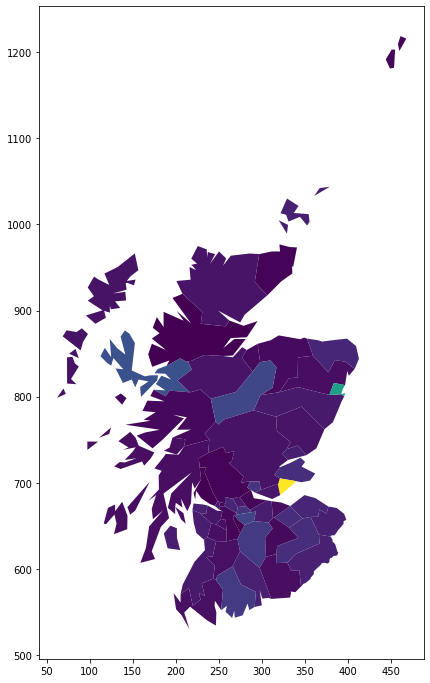

In [95]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot()
df.plot('expected', ax=ax)

In [97]:
node1, node2 = nb_to_graph(geo_to_nb(df))

  0%|          | 0/56 [00:00<?, ?it/s]

In [421]:
data = dict(
    N = len(df),
    N_edges = node1.size,
    node1 = node1 + 1,
    node2 = node2 + 1,
    y = df['cases'].to_numpy(),
    x = df['AFF'].to_numpy() * 10.,
    E = df['expected'].to_numpy(),
)
data['log_E'] = np.log(data['E'])

In [419]:
sm = cmdstanpy.CmdStanModel(stan_file='../jx/stanmodels/bym_predictor_plus_offset.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling


In [458]:
samples = sm.sample(data, chains=4, show_progress='notebook')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcsjcqbts/vu__vj1r.json
DEBUG:cmdstanpy:cmd: /home/js/programs/jx/jx/stanmodels/bym_predictor_plus_offset info
cwd: None
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/home/js/programs/jx/jx/stanmodels/bym_predictor_plus_offset', 'id=3', 'random', 'seed=8092', 'data', 'file=/tmp/tmpcsjcqbts/vu__vj1r.json', 'output', 'file=/tmp/tmpcsjcqbts/bym_predictor_plus_offset-20220425014135_3.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/home/js/programs/jx/jx/stanmodels/bym_predictor_plus_offset', 'id=1', 'random', 'seed=8092', 'data', 'file=/tmp/tmpcsjcqbts/vu__vj1r.json', 'output', 'file=/tmp/tmpcsjcqbts/bym_predictor_plus_offset-20220425014135_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/home/js/programs/jx/jx/stanmodels/bym_predictor_plus_offset', 'id=4', 'random', 'seed=8092', 'data', 'file=/tmp/t

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/home/js/programs/jx/jx/stanmodels/bym_predictor_plus_offset', 'id=1', 'random', 'seed=8092', 'data', 'file=/tmp/tmpcsjcqbts/vu__vj1r.json', 'output', 'file=/tmp/tmpcsjcqbts/bym_predictor_plus_offset-20220425014135_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpcsjcqbts/bym_predictor_plus_offset-20220425014135_1.csv
 console_msgs (if any):
	/tmp/tmpcsjcqbts/bym_predictor_plus_offset-20220425014135_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.8000000000000

In [428]:
params = dict(
    beta0 = jnp.zeros(1), # intercept
    beta1 = jnp.zeros(1), # slope
    log_tau_theta = jnp.zeros(1), # precision of heterogeneous effects
    log_tau_phi = jnp.zeros(1), # precision of spatial effects
    theta = jnp.zeros(data['N']), # heterogeneous effects
    phi = jnp.zeros(data['N']), # spatial effects
)

In [336]:
def model():
    beta0 = numpyro.sample("beta0", dist.Normal(0., 5.))
    beta1 = numpyro.sample("beta1", dist.Normal(0., 5.))
    tau_theta = numpyro.sample("tau_theta", dist.Gamma(3.2761, 1.81))
    tau_phi = numpyro.sample("tau_phi", dist.Gamma(1., 1.))
    
    phi = numpyro.param("phi", jnp.zeros(data['N']))
    with numpyro.plate("n", data['N']):
        theta = numpyro.sample("theta", dist.Normal(0., 1.))
    
    numpyro.sample("soft-sum-to-zero", dist.Normal(0., 0.001), obs=jnp.mean(phi))
    
    phidiff = phi[data['node1']] - phi[data['node2']]
    numpyro.factor("phi_prior", -0.5 * jnp.dot(phidiff, phidiff))
    
    sigma_theta = 1. / jnp.sqrt(tau_theta)
    sigma_phi = 1. / jnp.sqrt(tau_phi)
    
    y = numpyro.sample(
        "y", 
        dist.Poisson(
            data['log_E'] + beta0 + \
            beta1 * data['x'] + \
            phi * sigma_phi + \
            theta * sigma_theta
        ), 
        obs=data['y']
    )

In [429]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=3000, num_samples=1000, num_chains=2, chain_method='vectorized')
mcmc.run(jax.random.PRNGKey(1))

sample: 100%|█████████████████████████████████████████████████████████████████████████| 4000/4000 [00:33<00:00, 120.55it/s]


In [461]:
samples_np = jax.tree_map(lambda x: x, mcmc.get_samples())

(<Figure size 705.6x705.6 with 16 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='beta1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='tau_phi'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:xlabel='beta0', ylabel='tau_theta'>,
         <AxesSubplot:xlabel='beta1'>, <AxesSubplot:xlabel='tau_phi'>,
         <AxesSubplot:xlabel='tau_theta'>]], dtype=object))

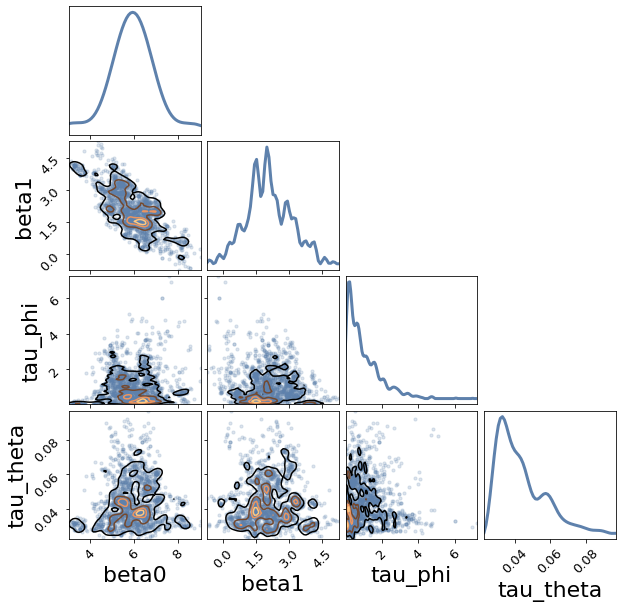

In [462]:
pears.pears(samples_np, indices=['beta0', 'beta1', 'tau_phi', 'tau_theta'])

In [433]:
@jax.jit
def ln_posterior(params, data):
    target = 0.
    
    tau_theta = jnp.exp(params['log_tau_theta'])
    tau_phi = jnp.exp(params['log_tau_phi'])
    sigma_theta = 1. / jnp.sqrt(tau_theta)
    sigma_phi = 1. / jnp.sqrt(tau_phi)
        
    phidiff = params['phi'][data['node1']] - params['phi'][data['node2']]
    target += -0.5 * jnp.dot(phidiff, phidiff)
    
    # soft sum-to-zero constraint on phi
    target += stats.norm.logpdf(jnp.mean(params['phi']), 0., 0.001)
    
    # priors
    target += stats.norm.logpdf(params['beta0'], 0., 5.)
    target += stats.norm.logpdf(params['beta1'], 0., 5.)
    target += stats.norm.logpdf(params['theta'], 0., 1.).sum()
    target += stats.gamma.logpdf(tau_theta, 3.2761, scale=1./1.81)
    target += stats.gamma.logpdf(tau_phi, 1., scale=1.)

    # likelihood
    target += jnp.sum(
        stats.poisson.logpmf(
            data['y'], 
            data['log_E'] + \
                params['beta0'] + \
                params['beta1'] * data['x'] + \
                params['phi'] * sigma_phi + \
                params['theta'] * sigma_theta
        )
    )
    
    return target.sum()

nll = lambda p: -ln_posterior(p, data)

In [434]:
losses = []

In [451]:
samples_mine = hmc.sample(ln_posterior, params, data=data, n_chains=2, n_warmup=5000)

Compiling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [281]:
for i in (pbar := tqdm(range(10_000))):
    try:
        old_grad = grad
    except:
        pass
    val, grad = jax.value_and_grad(nll)(params)
    try:
        grad = jax.tree_multimap(lambda g1, g2: 0.1 * g1 + 0.9 * g2, grad, old_grad)
    except: 
        pass
    
    if val > -10000 and jax.tree_util.tree_reduce(operator.add, jax.tree_map(lambda x: jnp.sum(~jnp.isfinite(x)), grad), 0).item() == 0:
        params = jax.tree_multimap(lambda p, g: p - 1e-4 * g, params, grad)
    else:
        break
    losses.append(val)
    if i % 20 == 0:
        pbar.set_description(f"{val:.2f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

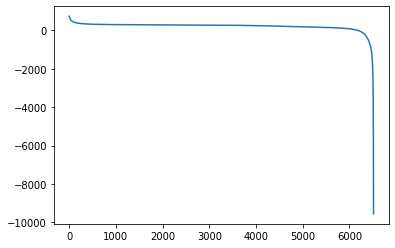

In [ ]:
plt.plot(losses)

In [205]:
@jax.jit
def sim(params, data):
    tau_theta = jnp.exp(params['log_tau_theta'])
    tau_phi = jnp.exp(params['log_tau_phi'])
    sigma_theta = 1. / jnp.sqrt(tau_theta)
    sigma_phi = 1. / jnp.sqrt(tau_phi)
    return jnp.exp(
        data['log_E'] + \
        params['beta0'] + \
        params['beta1'] * data['x'] + \
        params['phi'] * sigma_phi + \
        params['theta'] * sigma_theta
    )

In [284]:
mu = sim(params, data)

<AxesSubplot:>

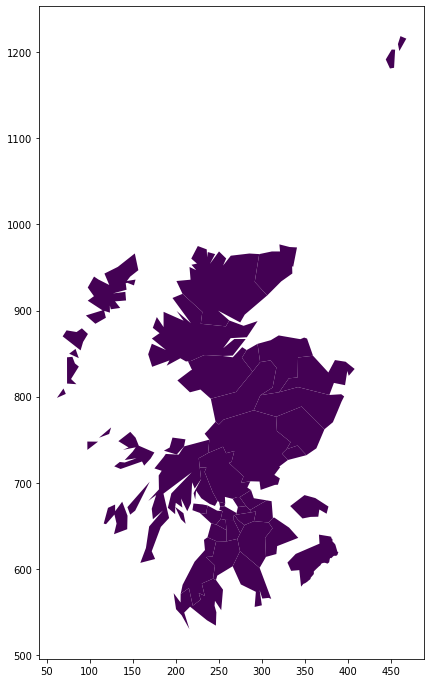

In [401]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot()
df.plot(np.array(mu), ax=ax)

<AxesSubplot:>

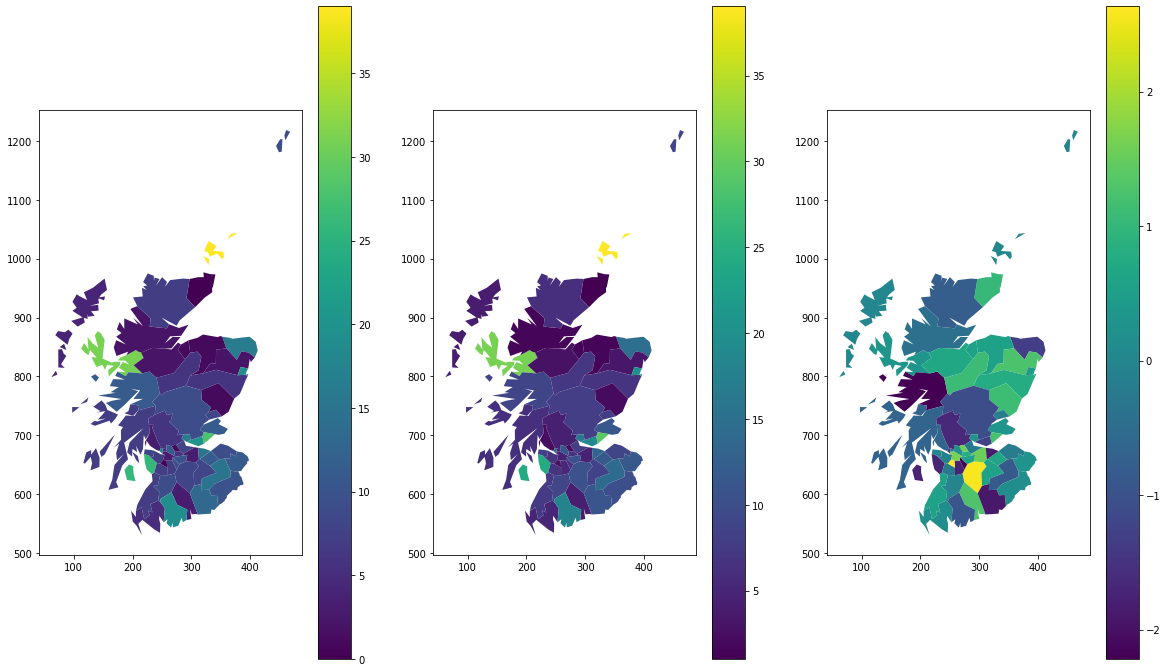

In [479]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
df.plot('cases', ax=ax1, legend=1)
df.plot(samples.stan_variable("mu").mean(axis=0), ax=ax2, legend=1)
df.plot(samples.stan_variable("mu").mean(axis=0) - df['cases'], ax=ax3, legend=1)

(array([ 6.,  4.,  4.,  4., 13., 12.,  5.,  6.,  0.,  2.]),
 array([-2.21681681, -1.73178603, -1.24675525, -0.76172448, -0.2766937 ,
         0.20833707,  0.69336785,  1.17839862,  1.6634294 ,  2.14846017,
         2.63349095]),
 <BarContainer object of 10 artists>)

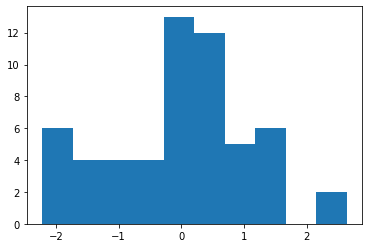

INFO:cmdstanpy:deleting tmpfiles dir: /tmp/tmpcsjcqbts
INFO:cmdstanpy:deleting tmpfiles dir: /tmp/tmpcsjcqbts
INFO:cmdstanpy:done
INFO:cmdstanpy:done


In [481]:
plt.hist(samples.stan_variable("mu").mean(axis=0) - df['cases'].to_numpy())

In [452]:
samples_mine = jax.tree_map(lambda x: x.reshape(-1, x.shape[1]), samples_mine)

In [464]:
samples_mine['beta0'].mean()

DeviceArray(4.055404, dtype=float32)

In [465]:
samples.stan_variable('beta0').mean()

-0.47054067695825

In [466]:
samples_np['beta0'].mean()

DeviceArray(5.9336557, dtype=float32)